In [1]:
import numpy as np
import os, sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits, flux_to_mag
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields, gaiaAEN
from cuts import getGeoCuts, bgsbut
from QA import getStats, flow, mollweide, mycmap, plot_sysdens, overdensity, hexbin

from QA import set_mwd, get_radec_mw
from io_ import get_isdes

import healpy as hp
import astropy.io.fits as fits
import fitsio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
from astropy.coordinates import SkyCoord
import astropy.units as units
from astropy.table import Table

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

## Load data sets

``` python
ran = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/dr9_random_N1.npy')
ex = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/extra_random_N1_n256.npy')

#
ran2 = Table()
mask = (ex['south']) & (ex['desi'])
ran2['RA'] = ran['RA'][mask]
ran2['DEC'] = ran['DEC'][mask]

np.save('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/randoms.npy', ran2)
```

``` python 
import h5py
filename = '/global/cscratch1/sd/qmxp55/bgstargets_output/MXXL/galaxy_catalogue.hdf5'

data = h5py.File(filename, "r")['Data']
header = h5py.File(filename, "r")['Header']

#
mxxl = Table()
for col in ['ra', 'dec', 'app_mag', 'g_r_obs_smooth']:
    
    mxxl[col] = data[col][:]
    
nside = 256
extra = Table()
extra['hppix'] = hp.ang2pix(nside,(90.-mxxl['dec'])*np.pi/180.,mxxl['ra']*np.pi/180.,nest=True)
print('healpix DONE...')
c = SkyCoord(mxxl['ra']*units.degree,mxxl['dec']*units.degree, frame='icrs')
extra['b'] = c.galactic.b.value # galb coordinate
extra['l'] = c.galactic.l.value # galb coordinate
print('galactic coordinates DONE...')

regs = ['des', 'decals', 'north', 'desi', 'south']
for i in regs:
    reg_ = get_reg(reg=i, hppix=extra['hppix'])
    extra[i] = reg_
    print(i, 'DONE...')
    
np.save('/global/cscratch1/sd/qmxp55/bgstargets_output/MXXL/galaxy_catalogue_extra.npy', extra)

mxxl2 = Table()
mask = (extra['south']) & (extra['desi'])
for col in ['ra', 'dec', 'app_mag', 'g_r_obs_smooth']:
    
    mxxl2[col.upper()] = mxxl[col][mask]
    
np.save('/global/cscratch1/sd/qmxp55/bgstargets_output/MXXL/galaxy_catalogue_south.npy', mxxl2)
```

In [2]:
#targets
targets = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/south_nominal.npy')
#targets MXXL
targets_mxxl = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/MXXL/galaxy_catalogue_south.npy')
#randoms
randoms = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/randoms.npy')

In [11]:
import Corrfunc
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
import time
from Corrfunc.utils import convert_3d_counts_to_cf

No handles with labels found to put in legend.


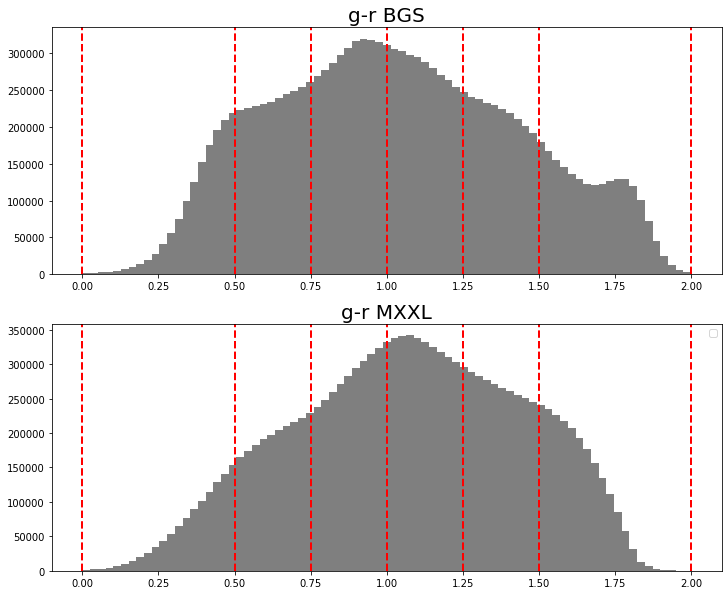

In [10]:
#
g_r_mxxl = targets_mxxl['g_r_obs_smooth'.upper()]
g_r = targets['GMAG']-targets['RMAG']
gr = {'g-r BGS':g_r, 'g-r MXXL':g_r_mxxl}
limits = np.array([0, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0])

plt.figure(figsize=(12,10))

for i, key, val in zip(range(len(gr.keys())), gr.keys(), gr.values()):
    
    plt.subplot(2,1,i+1)
    bins = np.linspace(0, 2, 80)
    plt.hist(val, bins=bins, color='k', alpha=0.5)
    plt.title(key, fontsize=20)
    
    for num, lim in enumerate(limits):
        plt.axvline(float(lim), lw=2, ls='--', color='red')

plt.legend()
plt.show()


0.0_0.5: 	 1386543
0.5_0.75: 	 2347306
0.75_1.0: 	 2962836
1.0_1.25: 	 2806690
1.25_1.5: 	 2186813
1.5_2.0: 	 1999561


No handles with labels found to put in legend.


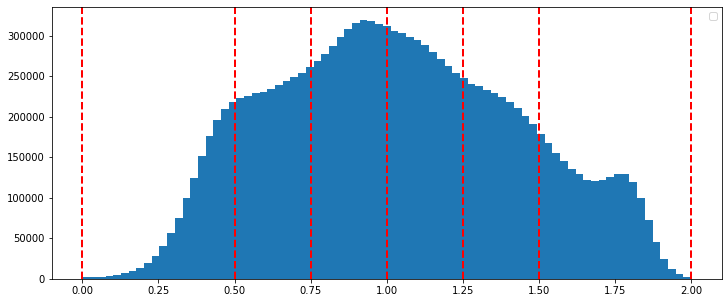

In [15]:
#
colours = {}
g_r = targets['GMAG']-targets['RMAG']
#g_r = targets['g_r_obs_smooth'.upper()]
#bgs = ((targets['BGSBITS'] & 2**(20)) != 0)
val = np.array([0, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0])#
#val = np.linspace(0,2,6)
for num, i in enumerate(val[:-1]):
    colours['%s_%s' %(str(val[num]), str(val[num+1]))] = (g_r > val[num]) & (g_r < val[num+1]) & (np.isfinite(g_r))
    
plt.figure(figsize=(12,5))
for key, val in colours.items():
    ini, fin = key.split('_')
    #bins = np.linspace(float(ini), float(fin), 50)
    plt.axvline(float(ini), lw=2, ls='--', color='red')
    if float(fin) > 1.5:
        plt.axvline(float(fin), lw=2, ls='--', color='red')
    
    print('%s: \t %i' %(key, np.sum(val)))
    
    #plt.hist(g_r[val], bins=bins, label=key)
bins = np.linspace(0, 2, 80)
plt.hist(g_r, bins=bins)
plt.legend()
    
plt.show()

$\omega(\theta)_{LS} = \frac{N_{dd} - 2 N_{dr} + \sum N_{rr}}{\sum N_{rr}}$

$\omega(\theta)_{H} = \frac{N_{dd} \cdot n \cdot \sum_{i}^{35} N_{rr}}{\sum_{i}^{35} N_{dr}^2} -1$

Hi Shaun,

I did what you suggested and splited the randoms (~50 M) in to samples with the same number as in targets sample. The target sample I've used is BGS within the region 0 < g-r < 0.5, with around 1.39 M galaxies, then, I split the randoms into 35 chunks, each with ~ 1.37 M objects. Then, angular clustering was computed with Hamilton estimatoras shown in Eq. below. The normalization factor, n, is the number of chunks i took, 35. Then I compare this results with the "true", which is using pairs count without spliting the randoms. First of all, this method is way faster than without spliting the randoms, I'm talking about 24 times faster. The DR pair counts are exactly the same, however, the RR counts are not, these are prety much alike at small scales but becomes highly different at scales above 0.4 deg. Below is the angular clustering plot, blue solid shows results without splitting the randoms, while orange dashed shows results when splitting the randoms. Next, I show a plot of the difference between RR (randoms-randoms) pair counts with nominal (no splitting) method minus the RR with the splitting method. Here we can see it gets noisy at large scales.

In [43]:
len(randoms)/16

3036234.3125

In [18]:
#get the index array
import random
idx = [i for i in range(len(randoms['RA']))]
#shuffle the array
random.shuffle(idx)

#split array in chunks
chunks = {}
n = 16
for i in range(n):
    chunks['%i' %(i)] = idx[i::n]

In [19]:
for key, val in chunks.items():
    print('%s: \t %i' %(key, len(val)))

0: 	 3036235
1: 	 3036235
2: 	 3036235
3: 	 3036235
4: 	 3036235
5: 	 3036234
6: 	 3036234
7: 	 3036234
8: 	 3036234
9: 	 3036234
10: 	 3036234
11: 	 3036234
12: 	 3036234
13: 	 3036234
14: 	 3036234
15: 	 3036234


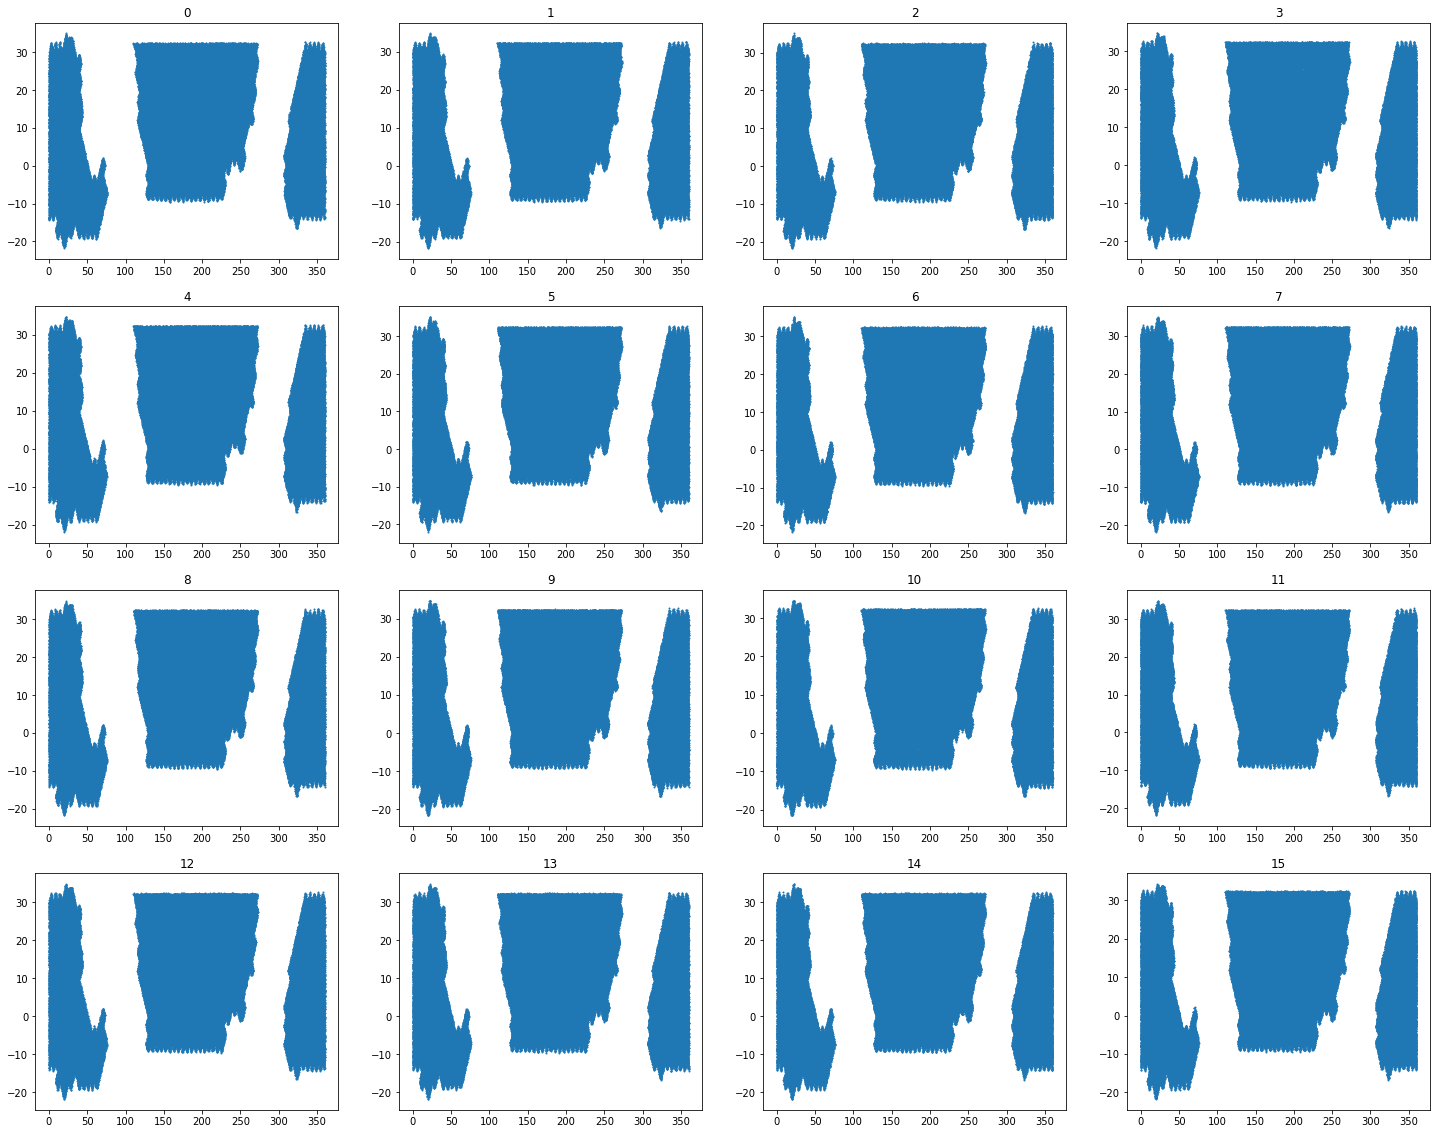

In [63]:
#
plt.figure(figsize=(25, 20))
for key, val in chunks.items():
    
    if int(key) < 16:
        plt.subplot(4, 4,int(key)+1)
        plt.scatter(randoms['RA'][val][::30], randoms['DEC'][val][::30], s=1)
        plt.title(key)

In [20]:
#
def read_clustering(mxxl=False):
    
    ac = {}

    #ran_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/RR_south_16.npy'
    ran_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/RR_0.0_0.5_2.npy'
    ran = np.load(ran_file, allow_pickle=True).item()

    for num, key in enumerate(colours.keys()):

        if mxxl:
            DD_DR_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/DD_DR_decals_16_%s_MXXL.npy' %(key)
        else:
            DD_DR_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/DD_DR_decals_16_%s.npy' %(key)
            
        DD_DR = np.load(DD_DR_file, allow_pickle=True).item()
        
        w = []
        bc = []

        DD_ = DD_DR['DD_%s' %(key)]
        DD = []

        for i in range(len(DD_)):

            DD.append(DD_[i][3])

        DR = np.full(len(DD_), 0)
        RR = np.full(len(DD_), 0)

        for keyR, val in chunks.items():
            ni = len(randoms)/len(val)
            for i in range(len(DD)):

                DR[i] += DD_DR['DR_%s_%s' %(key, keyR)][i][3]
                RR[i] += ni * ran['RR_%s' %(keyR)][i][3]
            #print('%s: \t %f' %(keyR, len(randoms)/len(val)))

        ac['RR'] = RR
        if num < 1:
            halfbin = (DD_[0][1] - DD_[0][0])/2.

            for i in range(len(DD)):

                bc.append(np.array(DD_[i][0]) + halfbin)

            ac['bs'] = bc

        ac['w_%s' %(key)] = ((np.array(DD) * RR)/DR**2) - 1
        
    return ac
    

In [21]:
ac_bgs = read_clustering(mxxl=False)

In [22]:
ac_mxxl = read_clustering(mxxl=True)

In [29]:
cmap = plt.get_cmap('jet', len(clist))

In [45]:
cmap(1)

(0.0, 0.8333333333333334, 1.0, 1.0)

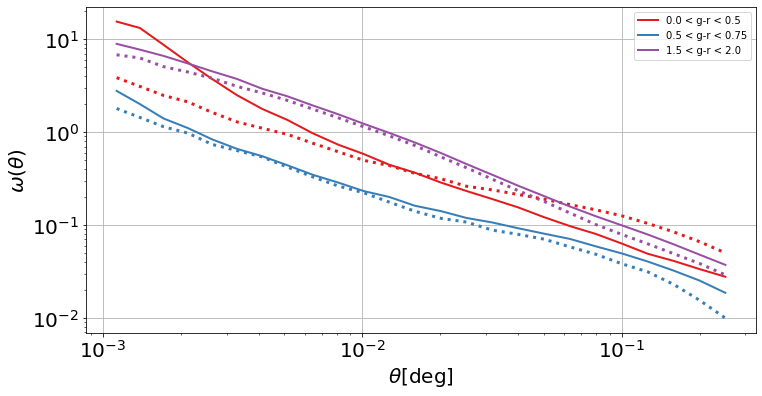

In [63]:
#
from matplotlib.pyplot import cm

fig = plt.figure(figsize=(12,6))
color=cm.Set1(np.linspace(0,1,len(colours.keys())))

#
N = 25

# clist = ['0.0_0.5', '0.5_0.75', '0.75_1.0', '1.0_1.25', '1.25_1.5', '1.5_2.0']
clist = ['0.0_0.5', '0.5_0.75', '1.5_2.0']
#cmap = plt.get_cmap('jet', len(clist))
for num, key in enumerate(clist):
    
    ini, fin = key.split('_')
    
    plt.loglog(ac_bgs['bs'][:N], ac_bgs['w_%s' %(key)][:N], lw=2, color=color[num], label='%s < g-r < %s' %(ini, fin))
    plt.loglog(ac_mxxl['bs'][:N], ac_mxxl['w_%s' %(key)][:N], lw=3, color=color[num], ls=':')

    #plt.legend(bbox_to_anchor=(1.1, 1.05))
    
plt.xlabel(r'$\theta$[deg]', fontsize=20)
plt.ylabel(r'$\omega(\theta)$', fontsize=20)
plt.legend()
plt.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
filefig = os.path.join('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/figures/', 'angular_clustering_color_bgs_mxxl')
fig.savefig(filefig+'.png', bbox_inches = 'tight', pad_inches = 0, dpi=300)

In [64]:
filefig

'/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/figures/angular_clustering_color_bgs_mxxl'

In [ ]:
#
fig = plt.figure(figsize=(12,6))

for key in ['0.0_0.5']:
    
    w = []
    w2 = []
    bc = []
    
    DD_ = pairs['DD_%s' %(key)]
    DR_ = pairs['DR_%s' %(key)]
    RR_ = rr_pairs
    DD2_ = pairs2['DD_%s' %(key)]
    
    RR = []
    DR = []
    DD = []
    DD2 = []
    
    for i in range(len(DD_)):
        
        RR.append(RR_[i][3])
        DR.append(DR_[i][3])
        DD.append(DD_[i][3])
        DD2.append(DD2_[i][3])
    
    DR2 = np.full(len(DD2), 0)
    RR2 = np.full(len(DD2), 0)
    
    for keyR, val in chunks.items():
        ni = len(randoms)/len(val)
        for i in range(len(DR2)):
    
            DR2[i] += pairs2['DR_%s_%s' %(key, keyR)][i][3]
            RR2[i] += ni * ran_pairs['RR_%s' %(keyR)][i][3]
        #print('%s: \t %f' %(keyR, len(randoms)/len(val)))
    
    halfbin = (DD_[0][1] - DD_[0][0])/2.

    for i in range(len(DD)):
        
        bc.append(np.array(DD_[i][0]) + halfbin)
        
    w = ((np.array(DD) * np.array(RR))/np.array(DR)**2) - 1
    w2 = ((np.array(DD2) * RR2)/DR2**2) - 1
        
    #
    N = 40
    plt.semilogx(bc[:N], w[:N], lw=3, label=key)
    plt.semilogx(bc[:N], w2[:N], lw=3, ls='--',label=key+' fast')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    
plt.xlabel(r'$\theta$', fontsize=15)
plt.ylabel(r'$\omega(\theta)$', fontsize=15)
#plt.ylim(0.7, 1)
plt.grid()

In [61]:
#
pairs2 = {}
nbins=40
nthreads=16
bins = np.logspace(np.log10(0.001), np.log10(10.0), nbins + 1) #log bins

for key in ['0.0_0.5']:
    
    val = colours[key]
    RA1, DEC1 = targets['RA'][val]'g_r_obs_smooth', targets['DEC'][val].astype('float64')
    
    start = time.time()
    pairs2['DD_%s' %(key)] = DDtheta_mocks(1, nthreads, bins, RA1, DEC1)
    end = time.time()
    print('DD run time: %f sec' %(end - start))
    
    for keyR, val in chunks.items():
        
        RAr, DECr = randoms['RA'][val].astype('float64'), randoms['DEC'][val].astype('float64')
        start = time.time()
        pairs2['DR_%s_%s' %(key, keyR)] = DDtheta_mocks(0, nthreads, bins, RAr, DECr, RA2=RA1, DEC2=DEC1)
        end = time.time()
        print('DR_%s_%s run time: %f sec' %(key, keyR, end - start))



DD run time: 16.374262 sec
DR_0.0_0.5_0 run time: 89.920160 sec
DR_0.0_0.5_1 run time: 87.759696 sec


Received signal = `Interrupt' (signo = 2). Aborting 


RuntimeError: RuntimeError occurred

In [59]:
rar = RA1.astype('float64')

In [60]:
type(rar[0])

numpy.float64

In [ ]:
np.save('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/DD_DR_0.0_0.5_2.npy', pairs2)

In [46]:
#
ran_pairs = {}
nbins=40
nthreads=16
bins = np.logspace(np.log10(0.001), np.log10(10.0), nbins + 1) #log bins

for keyR, val in chunks.items():

    RAr, DECr = randoms['RA'][val], randoms['DEC'][val]

    start = time.time()
    ran_pairs['RR_%s' %(keyR)] = DDtheta_mocks(0, nthreads, bins, RAr, DECr, RA2=RAr, DEC2=DECr)
    end = time.time()
    print('RR_%s run time: %f sec' %(keyR, end - start))


RR_0 run time: 123.230765 sec
RR_1 run time: 112.342793 sec


KeyboardInterrupt: 

In [35]:
np.save('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/RR_0.0_0.5.npy', ran_pairs)

In [72]:
#
limits = [160, 180, 5, 7]
pairs = {}
nbins=40
nthreads=16

mask_tar = select_patch([targets['RA'], targets['DEC']], limits=limits)
mask_ran = select_patch([randoms['RA'], randoms['DEC']], limits=limits)

bins = np.logspace(np.log10(0.001), np.log10(10.0), nbins + 1) #log bins

for key, val in colours.items():
    
    keep_tar = (mask_tar) & (val)
    RA1, DEC1 = targets['RA'][keep_tar], targets['DEC'][keep_tar]
    RAr, DECr = randoms['RA'][mask_ran], randoms['DEC'][mask_ran]

    start = time.time()
    pairs['DD_%s' %(key)] = DDtheta_mocks(1, nthreads, bins, RA1, DEC1)
    end = time.time()
    print('DD run time: %f sec' %(end - start))

    start = time.time()
    pairs['DR_%s' %(key)] = DDtheta_mocks(0, nthreads, bins, RAr, DECr, RA2=RA1, DEC2=DEC1)
    end = time.time()
    print('DR run time: %f sec' %(end - start))

DD run time: 0.028990 sec
DR run time: 1.014073 sec
DD run time: 0.353851 sec
DR run time: 3.156461 sec
DD run time: 0.302303 sec
DR run time: 3.095788 sec
DD run time: 0.071048 sec
DR run time: 1.348053 sec


In [28]:
start = time.time()
RR = DDtheta_mocks(0, nthreads, bins, RAr, DECr, RA2=RAr, DEC2=DECr)
end = time.time()
print('RR run time: %f sec' %(end - start))

RR run time: 27.458028 sec


In [2]:
pairs = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/DD_DR_counts_randoms1_south_nominal.npy', 
              allow_pickle=True).item()
rr_pairs = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/RR_counts_randoms1_south_nominal.npy')

pairs2 = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/DD_DR_0.0_0.5_2.npy', 
              allow_pickle=True).item()

ran_pairs = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/RR_0.0_0.5_2.npy', 
              allow_pickle=True).item()

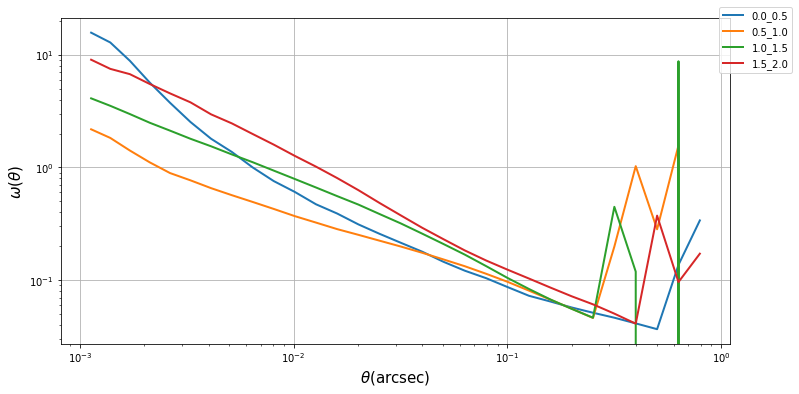

In [11]:
#
fig = plt.figure(figsize=(12,6))

for key, val in colours.items():
    
    w = []
    bc = []
    
    DD_ = pairs['DD_%s' %(key)]
    DR_ = pairs['DR_%s' %(key)]
    RR_ = rr_pairs
    
    RR = []
    DR = []
    DD = []
    
    for i in range(len(DD_)):
        
        RR.append(RR_[i][3])
        DR.append(DR_[i][3])
        DD.append(DD_[i][3])
    
    halfbin = (DD_[0][1] - DD_[0][0])/2.

    for i in range(len(DD)):
        
        bc.append(np.array(DD_[i][0]) + halfbin)
        
    w = ((np.array(DD) * np.array(RR))/np.array(DR)**2) - 1
        
    #
    N = 30
    plt.loglog(bc[:N], w[:N], lw=2, label=key)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    
plt.xlabel(r'$\theta$(arcsec)', fontsize=15)
plt.ylabel(r'$\omega(\theta)$', fontsize=15)
#plt.ylim(0., 20)
plt.grid()

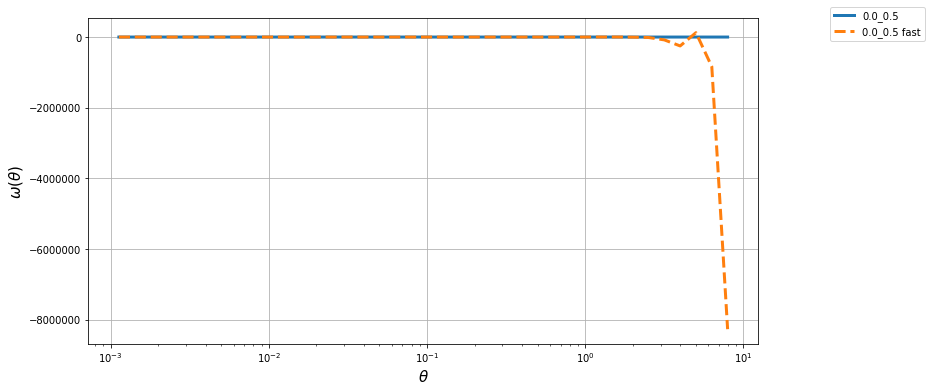

In [24]:
#
fig = plt.figure(figsize=(12,6))

for key in ['0.0_0.5']:
    
    w = []
    w2 = []
    bc = []
    
    DD_ = pairs['DD_%s' %(key)]
    DR_ = pairs['DR_%s' %(key)]
    RR_ = rr_pairs
    DD2_ = pairs2['DD_%s' %(key)]
    
    RR = []
    DR = []
    DD = []
    DD2 = []
    
    for i in range(len(DD_)):
        
        RR.append(RR_[i][3])
        DR.append(DR_[i][3])
        DD.append(DD_[i][3])
        DD2.append(DD2_[i][3])
    
    DR2 = np.full(len(DD2), 0)
    RR2 = np.full(len(DD2), 0)
    
    for keyR, val in chunks.items():
        ni = len(randoms)/len(val)
        for i in range(len(DR2)):
    
            DR2[i] += pairs2['DR_%s_%s' %(key, keyR)][i][3]
            RR2[i] += ni * ran_pairs['RR_%s' %(keyR)][i][3]
        #print('%s: \t %f' %(keyR, len(randoms)/len(val)))
    
    halfbin = (DD_[0][1] - DD_[0][0])/2.

    for i in range(len(DD)):
        
        bc.append(np.array(DD_[i][0]) + halfbin)
        
    w = ((np.array(DD) * np.array(RR))/np.array(DR)**2) - 1
    w2 = ((np.array(DD2) * RR2)/DR2**2) - 1
        
    #
    N = 40
    plt.semilogx(bc[:N], w[:N], lw=3, label=key)
    plt.semilogx(bc[:N], w2[:N], lw=3, ls='--',label=key+' fast')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    
plt.xlabel(r'$\theta$', fontsize=15)
plt.ylabel(r'$\omega(\theta)$', fontsize=15)
#plt.ylim(0.7, 1)
plt.grid()

In [20]:
for i in range(len(w)):
    print(RR[i], RR2[i])

440930 3951131
696778 6361979
1105678 9928283
1747670 15776891
2769250 24944219
4386908 39404123
6944354 62483579
10994470 99065147
17428600 156897275
27594768 248386630
43661538 392945073
69183538 622757372
109581042 986577677
173561392 1562132137
274891708 2473978171
435476548 3920144225
689812532 6210498329
1092791820 9836004940
1730949934 15581921460
2741783926 24677164772
4342174778 39088184992
6876265874 61896614954
10887948862 98007276734
17236065802 155146728253
27275326826 245521345212
43145509616 388377043572
68213327048 614031122275
107794130950 970300861322
170203665218 1532097329348
268509564462 2416964977993
423108615030 3808586119373
665804815102 5993202111047
1045971951040 9415198578326
1639954727656 14761681612131
2565315508190 23090998112782
4002183742780 36024361692458
6219791302904 55985551352979
9600718195250 86418370704912
14688651004340 132214700145184
22244181163996 200221117134243


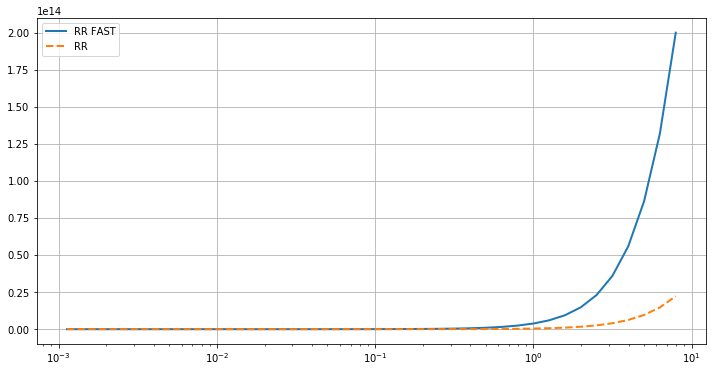

In [21]:
plt.figure(figsize=(12,6))

#plt.axhline(1, lw=1, ls='--', color='r')
plt.semilogx(bc, RR2, ls='-', lw=2, label='RR FAST')
plt.semilogx(bc, RR, ls='--', lw=2, label='RR')
plt.legend()
plt.grid()

In [109]:
rr_pairs = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/RR_counts_randoms1_south_nominal.npy')

In [113]:
#
RR_slow = []
for i in range(len(rr_pairs)):
    RR_slow.append(rr_pairs[i][3])

In [114]:
RR_slow

[440930,
 696778,
 1105678,
 1747670,
 2769250,
 4386908,
 6944354,
 10994470,
 17428600,
 27594768,
 43661538,
 69183538,
 109581042,
 173561392,
 274891708,
 435476548,
 689812532,
 1092791820,
 1730949934,
 2741783926,
 4342174778,
 6876265874,
 10887948862,
 17236065802,
 27275326826,
 43145509616,
 68213327048,
 107794130950,
 170203665218,
 268509564462,
 423108615030,
 665804815102,
 1045971951040,
 1639954727656,
 2565315508190,
 4002183742780,
 6219791302904,
 9600718195250,
 14688651004340,
 22244181163996]

In [120]:
ac_bgs['RR']

array([        437499,         718907,        1095227,        1756027,
              2772347,        4379739,        6970587,       11034171,
             17431323,       27612027,       43663835,       69145115,
            109626006,      173467964,      274790359,      435620179,
            690013786,     1093040413,     1731233532,     2741943320,
           4342945747,     6877507770,    10889778235,    17238490933,
          27281177750,    43152016376,    68226547636,   107815062297,
         170236351738,   268558471320,   423190199736,   665943734844,
        1046189861630,  1640267344968,  2565784672980,  4002861748619,
        6220815382481,  9602494111081, 14691471052960, 22248529178895])

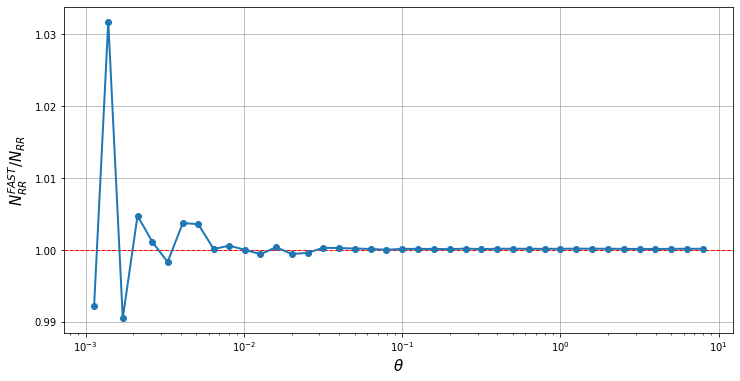

In [121]:
# RR_ = []
# DR_ = []
# for i in range(len(DD)):
#     RR_.append(RR[i][3])
#     DR_.append(DR[i][3])
    #print(RR[i][3], 35*RR2[i])

plt.figure(figsize=(12,6))
#plt.hist(A, 80, histtype='step', ls='-', label='normal')
#plt.hist(n*RR2, 80, histtype='step', ls='--', label='fast')
plt.axhline(1, lw=1, ls='--', color='r')
plt.semilogx(ac_bgs['bs'], ac_bgs['RR']/np.array(RR_slow), ls='-', marker='o', lw=2)

#plt.plot(bc, n*RR2, ls='--', lw=2, label='fast RR')

#plt.plot(bc, DR_, ls='-', lw=2, label='normal DR')
#plt.plot(bc, DR2, ls='--', lw=2, label='fast DR')

#plt.plot(bc, DD_, ls='-', lw=2, label='normal DR')
#plt.plot(bc, DD2, ls='--', lw=2, label='fast DR')

    
plt.xlabel(r'$\theta$', fontsize=15)
plt.ylabel(r'$N_{RR}^{FAST}/N_{RR}$', fontsize=15)

plt.grid()

In [6]:
import Corrfunc
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
import time
from Corrfunc.utils import convert_3d_counts_to_cf

def select_patch(cat, limits):
    
    patch = np.ones(len(cat[0]), bool)
    patch &= np.logical_and(cat[0] > limits[0], cat[0] < limits[1])
    patch &= np.logical_and(cat[1] > limits[2], cat[1] < limits[3])
    
    return patch


def density_in_CC(cat1, cat2, RAND, nbins=40, nthreads=8):
    
    #if limits is None:
    #    raise ValueError('limits can not be None-type...')
        
    #bins = np.linspace(0.1, 10.0, nbins + 1) # note the +1 to nbins
    bins = np.logspace(np.log10(0.001), np.log10(10.0), nbins + 1) #log bins
    #rand_N = len(RAND[0])
    #print('etaR:', etaR)
    
    if cat2 is not None:
        start = time.time()
        D1D2_ = DDtheta_mocks(0, nthreads, bins, cat1[0], cat1[1], RA2=cat2[0], DEC2=cat2[1])
        end = time.time()
        print('D1D2 run time: %f sec' %(end - start))
    
        start = time.time()
        D2R_ = DDtheta_mocks(0, nthreads, bins, RAND[0], RAND[1], RA2=cat2[0], DEC2=cat2[1])
        end = time.time()
        print('D2R run time: %f sec' %(end - start))
    
    else:
        start = time.time()
        D1D2_ = DDtheta_mocks(1, nthreads, bins, cat1[0], cat1[1])
        end = time.time()
        print('D1D1 run time: %f sec' %(end - start))
    
        start = time.time()
        D2R_ = DDtheta_mocks(0, nthreads, bins, RAND[0], RAND[1], RA2=cat1[0], DEC2=cat1[1])
        end = time.time()
        print('D1R run time: %f sec' %(end - start))
    
    eta = []
    binsCentre = []
    halfbin = (D1D2_[0][1] - D1D2_[0][0])/2.
    for i in range(len(D1D2_)):
        binsCentre.append(D1D2_[i][0]+halfbin)
        #if D2R_[i][3] == 0:
        #    eta.append(0)
        #else:
        eta.append(D1D2_[i][3]/D2R_[i][3])
    
    return np.array(binsCentre), np.array(eta)


def get_cross_corr(cat1, cat2, randoms, MASK=None, MASK_ran=None, cat2_mag=None, limits=None, mag_list=None):
    '''
    cat1 and Randoms does not have to include any mask as this are used to get the reduced area for the densities.
    '''
    
    if (cat2_mag is None) or (limits is None) or (mag_list is None):
        raise ValueError('cat2_mag, limits and mag_list can not be None-type...')
        
    patch = select_patch(cat1, limits=limits)
    patch2 = select_patch(cat2, limits=limits)
    patch_ran = select_patch(randoms, limits=limits)
    
    if MASK is None:
        MASK = np.ones(len(cat1[0]))
    if MASK_ran is None:
        MASK_ran = np.ones(len(randoms[0]))

    RA, DEC = cat1[0][(MASK) & (patch)], cat1[1][(MASK) & (patch)]
    RA2, DEC2 = cat2[0][(patch2)]*1, cat2[1][(patch2)]*1 #We've to multiply tycho2 positios by 1 otherwise we have a weir issue
    RA_ran, DEC_ran = randoms[0][(MASK_ran) & (patch_ran)], randoms[1][(MASK_ran) & (patch_ran)]
    
    A = get_area(patch=limits, get_val=True)
    etaR = np.sum(patch_ran)/A #NR/A Total number of Randoms (NR) over total area within patch (A)
    eta_bgs = len(RA)*etaR/len(RA_ran) #Nbgs/Ar Total number of bgs (Nbgs) over reduced area (Ar)
    
    ###---------- Computing the primary (expensier) paircounts ----------
    
    eta_primary = Table()
    eta_secondary = Table()
    #Auto-corr cat2
    bins, eta_cat2 = density_in_CC(cat1=[RA2, DEC2], cat2=None, RAND=[RA_ran, DEC_ran], nbins=40, nthreads=16)
    #Auto-corr BGS
    _, eta_cat1 = density_in_CC(cat1=[RA, DEC], cat2=None, RAND=[RA_ran, DEC_ran], nbins=40, nthreads=16)
    #D1R/RR -- expensier computation used to get the angular clustering of the cross-corr with Hamilton estimator
    _, eta_CC = density_in_CC(cat1=[RA, DEC], cat2=[RA_ran, DEC_ran], RAND=[RA_ran, DEC_ran], nbins=40, nthreads=16)
    
    eta_primary['bins'] = bins
    eta_primary['auto_cat2'] = eta_cat2
    eta_primary['auto_cat1'] = eta_cat1
    eta_primary['D1R/RR'] = eta_CC
    
    ###---------- Computing the secondary (fatest) paircounts ----------
    
    for i in range(len(mag_list)-1):

        mag = np.logical_and(cat2_mag > mag_list[i], cat2_mag < mag_list[i+1])
        RA2, DEC2 = cat2[0][(patch2) & (mag)], cat2[1][(patch2) & (mag)]
        bins, eta_mag = density_in_CC(cat1=[RA, DEC], cat2=[RA2, DEC2], RAND=[RA_ran, DEC_ran], nbins=40, nthreads=16)
        
        col_label = '%i<cat2_mag<%i' %(mag_list[i], mag_list[i+1])
        
        if i == 0:
            eta_secondary['bins'] = bins
        eta_secondary[col_label] = eta_mag
    
    return eta_primary, eta_secondary, etaR, eta_bgs

def plot_cross_corr(cat1_name, cat2_name, eta_primary, eta_secondary, etaR, eta_bgs, ylimU=None, xlimU=None, ylimD=None, xlimD=None):
    #Figure
    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)

    ax1.semilogx(eta_primary['bins']*3600, eta_primary['auto_cat2']*etaR, lw=2, ls='--', color='orange', label='auto-corr %s' %(cat2_name))
    ax1.semilogx(eta_primary['bins']*3600, eta_primary['auto_cat1']*etaR, lw=2, ls='--', color='royalblue', label='auto-corr %s' %(cat1_name))
    
    ax1.axhline(eta_bgs, ls='--', lw=2, color='k', label='$\eta$_bgs=%2.5g' %(eta_bgs))
    ax2.axhline(0, ls='--', lw=2, color='k')

    for i,j in enumerate(eta_secondary.colnames[1:]):

        #Plotting the density cross-corr
        ax1.set_title(r'cat2:%s' %(cat2_name))
        ax1.semilogx(eta_secondary['bins']*3600, eta_secondary[j]*etaR, lw=2, label='%s' %(j))
        #Plotting the angular cross-corr w(theta)
        ax2.semilogx(eta_secondary['bins']*3600, (eta_secondary[j]/eta_primary['D1R/RR'])-1., lw=2, label='%s' %(j))

    #ax1.set_xlabel(r'$\theta$(arcsec)', fontsize=15)
    ax1.set_ylabel(r'$\eta_{BGS}$', fontsize=15)
    ax1.legend(bbox_to_anchor=(1.1, 1.05))
    ax1.grid()

    ax2.set_xlabel(r'$\theta$(arcsec)', fontsize=15)
    ax2.set_ylabel(r'$\omega(\theta)$', fontsize=15)
    #ax2.legend(bbox_to_anchor=(1.1, 1.05))
    ax2.grid()
    
    if ylimU is not None:
        ax1.set_ylim(ylimU)
    if ylimD is not None:
        ax2.set_ylim(ylimD)
